In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.woe import WOEEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, median_absolute_error, roc_auc_score
import warnings
warnings.simplefilter('ignore')

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [113]:
from scipy.stats import gaussian_kde

In [2]:
data = pd.read_csv('credit_dataset.csv')

# Preparar categorías para Target Mapping

In [4]:
data.loc[:, ['id','loan_status']].groupby(['loan_status']).count()

,id
loan_status,
Charged Off,42475
Current,224226
Default,832
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1988
Fully Paid,184739
In Grace Period,3146
Late (16-30 days),1218
Late (31-120 days),6900


In [5]:
loan_stat_cat = [
    'Fully Paid', 
    'Default', 
    'In Grace Period', 
    'Late (16-30 days)', 
    'Late (31-120 days)']

data = data[data['loan_status'].isin(loan_stat_cat)]

# Eliminación de columnas con >80% de datos nulos y Varianza 0

In [6]:
#Limpieza de columnas, eliminar columnas con 100% de datos nulos
null_cols = []
for column in data:
    nulls = data[column].isnull().sum()
    n = len(data)
    # Proporción de nulos
    nulls_rel = 100 * nulls / n
    
    if nulls_rel > 80:
        null_cols.append(column)

In [9]:
print(null_cols)

['mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


In [8]:
data = data.drop(columns=null_cols)
data = data.drop(['Unnamed: 0','member_id'], axis=1)
data = data.set_index('id')

In [10]:
# Columnas con 1 dato único (Varianza 0/constante)
c = []
for col in data:
    n = len(data[col].unique())
    if n == 1:
        c.append(col)
c

['recoveries', 'collection_recovery_fee', 'policy_code', 'application_type']

In [11]:
data = data.drop(columns=c)

In [15]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_rec_int,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
id,,,,,,,,,,,,,,,,,,,,,
1077501,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,861.07,0.00,Jan-15,171.62,Jan-16,0.0,0.0,NaN,NaN,NaN
1077175,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,603.65,0.00,Jun-14,649.91,Jan-16,0.0,0.0,NaN,NaN,NaN
1076863,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,2209.33,16.97,Jan-15,357.48,Jan-15,0.0,0.0,NaN,NaN,NaN
1075269,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,631.38,0.00,Jan-15,161.03,Sep-15,0.0,0.0,NaN,NaN,NaN
1072053,3000,3000,3000.0,36 months,18.64,109.43,E,E1,MKC Accounting,9 years,...,938.14,0.00,Jan-15,111.34,Dec-14,0.0,0.0,NaN,NaN,NaN


# Definición de target


Distribución de la variable objetivo (PD):
PD
0    184739
1     12096
Name: count, dtype: int64
Proporción de defaults: 0.0615


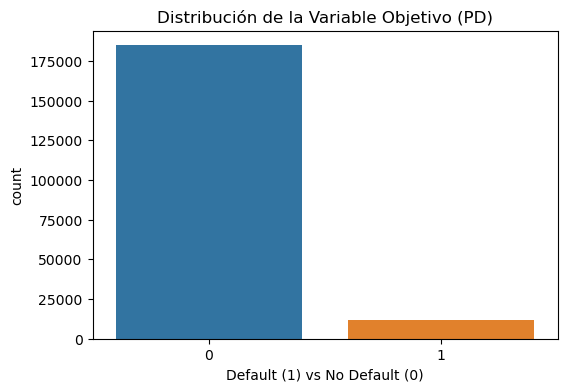

In [16]:
def map_target(status):
    if status == 'Fully Paid':
        return 0
    elif status in ['Default', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']:
        return 1
    else:
        return np.nan

data['PD'] = data['loan_status'].apply(map_target)

data = data.dropna(subset=['PD'])

print("\nDistribución de la variable objetivo (PD):")
pd_counts = data['PD'].value_counts()
print(pd_counts)
print(f"Proporción de defaults: {pd_counts[1]/len(data):.4f}")

plt.figure(figsize=(6,4))
sns.countplot(x='PD', data=data)
plt.title('Distribución de la Variable Objetivo (PD)')
plt.xlabel('Default (1) vs No Default (0)')
plt.show()

In [23]:
#Eliminar columnas no predictoras
data = data.drop(['url','title', 'loan_status'], axis=1)

# Tratamiento de Outliers

In [24]:
def handle_outliers(df, col):
    df = df.copy()  # Para no modificar el DataFrame original directamente

    if col == 'PD':
        return df, False, 0, col  # No modificar si es la columna 'PD'

    try:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers = outlier_mask.sum()

        if outliers > 0:
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)  # Ajusta los outliers
            return df, True, outliers, col

        return df, False, 0, col

    except Exception as e:
        print(f"Error al procesar la columna '{col}': {e}")
        return df, False, 0, col


In [25]:
df = data.copy()
numerics = data.select_dtypes(include=['number']).columns
columns_with_outliers = []

for col in numerics:
    df_model, has_outliers, count, col = handle_outliers(df, col)
    if has_outliers:
        columns_with_outliers.append((col, count))

In [26]:
df_model.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,PD
id,,,,,,,,,,,,,,,,,,,,,
1077501,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,0.00,Jan-15,171.62,Jan-16,0.0,0.0,NaN,NaN,NaN,0
1077175,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,0.00,Jun-14,649.91,Jan-16,0.0,0.0,NaN,NaN,NaN,0
1076863,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,16.97,Jan-15,357.48,Jan-15,0.0,0.0,NaN,NaN,NaN,0
1075269,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,0.00,Jan-15,161.03,Sep-15,0.0,0.0,NaN,NaN,NaN,0
1072053,3000,3000,3000.0,36 months,18.64,109.43,E,E1,MKC Accounting,9 years,...,0.00,Jan-15,111.34,Dec-14,0.0,0.0,NaN,NaN,NaN,0


# Generar bins para categorías numéricas

In [28]:
numerics = df_model.select_dtypes(include=['number']).columns
numerics

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'PD'],
      dtype='object')

In [29]:
df = df_model.copy()
for col in numerics:
    try:
        df[col] = pd.qcut(data[col], q=5)
    except:
        pass

In [30]:
#Visualizar categorías
cat = df.select_dtypes(include=['category']).columns 
df[cat].head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim
id,,,,,,,,,,,,,,,,,,,
1077501,"(499.999, 6075.0]","(499.999, 6050.0]","(-0.001, 6000.0]","(9.63, 12.12]","(15.689, 206.03]","(2999.999, 42000.0]","(22.862, 39.99]",NaN,"(-0.001, 7.0]","(13544.0, 21730.0]","(77.6, 892.3]","(1.999, 15.0]","(372.569, 6744.963]","(-0.001, 6651.196]","(236.539, 6000.0]","(630.828, 1157.938]","(-0.001, 483.156]",NaN,NaN
1077175,"(499.999, 6075.0]","(499.999, 6050.0]","(-0.001, 6000.0]","(14.3, 16.99]","(15.689, 206.03]","(2999.999, 42000.0]","(-0.001, 9.18]",NaN,"(-0.001, 7.0]","(-0.001, 4965.0]","(77.6, 892.3]","(1.999, 15.0]","(372.569, 6744.963]","(-0.001, 6651.196]","(236.539, 6000.0]","(-0.001, 630.828]","(483.156, 2989.776]",NaN,NaN
1076863,"(6075.0, 10000.0]","(6050.0, 10000.0]","(6000.0, 10000.0]","(12.12, 14.3]","(317.54, 421.18]","(42000.0, 55000.0]","(17.91, 22.862]","(26.0, 39.0]","(9.0, 11.0]","(4965.0, 8761.0]","(-0.001, 31.4]","(34.0, 150.0]","(10825.84, 15034.26]","(10729.726, 14896.498]","(9600.0, 12950.0]","(1878.834, 3139.208]","(-0.001, 483.156]",NaN,NaN
1075269,"(499.999, 6075.0]","(499.999, 6050.0]","(-0.001, 6000.0]","(5.419, 9.63]","(15.689, 206.03]","(2999.999, 42000.0]","(9.18, 13.7]",NaN,"(7.0, 9.0]","(4965.0, 8761.0]","(-0.001, 31.4]","(1.999, 15.0]","(372.569, 6744.963]","(-0.001, 6651.196]","(236.539, 6000.0]","(630.828, 1157.938]","(-0.001, 483.156]",NaN,NaN
1072053,"(499.999, 6075.0]","(499.999, 6050.0]","(-0.001, 6000.0]","(16.99, 26.06]","(15.689, 206.03]","(42000.0, 55000.0]","(-0.001, 9.18]",NaN,"(-0.001, 7.0]","(4965.0, 8761.0]","(77.6, 892.3]","(1.999, 15.0]","(372.569, 6744.963]","(-0.001, 6651.196]","(236.539, 6000.0]","(630.828, 1157.938]","(-0.001, 483.156]",NaN,NaN


# Evaluar columnas categóricas

In [33]:
obj = df.select_dtypes(include=['object']).columns


In [32]:
df[obj].head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,desc,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d
id,,,,,,,,,,,,,,,,,
1077501,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-11,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,860xx,AZ,Jan-85,f,Jan-15,Jan-16
1077175,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,n,NaN,small_business,606xx,IL,Nov-01,f,Jun-14,Jan-16
1076863,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,n,Borrower added on 12/21/11 > to pay for prop...,other,917xx,CA,Feb-96,f,Jan-15,Jan-15
1075269,36 months,A,A4,Veolia Transportaton,3 years,RENT,Source Verified,Dec-11,n,NaN,wedding,852xx,AZ,Nov-04,f,Jan-15,Sep-15
1072053,36 months,E,E1,MKC Accounting,9 years,RENT,Source Verified,Dec-11,n,Borrower added on 12/16/11 > Downpayment for...,car,900xx,CA,Jan-07,f,Jan-15,Dec-14


In [34]:
df = df.drop(['grade','desc','addr_state','zip_code','emp_title'], axis=1)

In [35]:
df.dtypes

loan_amnt                     category
funded_amnt                   category
funded_amnt_inv               category
term                            object
int_rate                      category
installment                   category
sub_grade                       object
emp_length                      object
home_ownership                  object
annual_inc                    category
verification_status             object
issue_d                         object
pymnt_plan                      object
purpose                         object
dti                           category
delinq_2yrs                    float64
earliest_cr_line                object
inq_last_6mths                 float64
mths_since_last_delinq        category
open_acc                      category
pub_rec                        float64
revol_bal                     category
revol_util                    category
total_acc                     category
initial_list_status             object
out_prncp                

# Selección de Características con WoE y IV

Separamos en train y test para aplicar WoEs

In [37]:
s = df.copy()

response = ['PD']
predictores = [c for c in s if c not in response]


train_x, test_x, train_y, test_y = train_test_split(s[predictores], 
                                                   s[response],
                                                   test_size=0.2,
                                                   random_state=28)

In [55]:
X = train_x[predictores]
y = train_y

# WoE Encoder
woe_encoder = WOEEncoder(cols=train_x.columns)
X_woe = woe_encoder.fit_transform(X, y)

# Resultado: DataFrame transformado
X_woe['PD'] = y

In [56]:
X_woe

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,...,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,PD
id,,,,,,,,,,,,,,,,,,,,,
547218,-0.205132,-0.205618,-0.202545,-0.286637,-1.188715,-0.092011,-1.443236,-0.206787,-0.090881,0.067969,...,-0.134395,-4.540643,1.185469,-4.416116,-0.007819,-0.003343,-2.735445,-2.735445,-2.735445,0
12506891,-0.205132,-0.205618,-0.202545,-0.286637,-0.012417,-0.092011,-0.330851,0.051912,0.075016,0.112908,...,-0.134395,-5.895729,-5.144045,0.889982,-0.007819,-0.003343,0.279291,0.383763,0.528528,0
1179429,-0.528803,-0.536421,-0.559965,-0.286637,-1.188715,-0.603765,-1.583920,-0.209786,-0.090881,-0.010456,...,-0.134395,-5.436902,0.821775,-4.466750,-0.007819,-0.003343,-2.735445,-2.735445,-2.735445,0
8064606,0.038690,0.031786,0.034560,-0.286637,0.672354,0.192125,0.622270,-0.206787,0.075016,0.067969,...,-0.134395,-5.989368,-5.144045,-4.736892,-0.007819,-0.003343,0.279291,0.442645,0.404384,0
1031471,-0.528803,-0.536421,-0.559965,-0.286637,-1.188715,-0.603765,-1.443236,-0.015311,0.075016,0.067969,...,-0.134395,-5.670196,1.185469,-4.959059,-0.007819,-0.003343,-2.735445,-2.735445,-2.735445,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846992,0.422840,0.433698,0.440719,0.750766,0.672354,0.273965,0.875391,0.002701,0.075016,0.067969,...,-0.134395,-4.971391,-5.434810,0.889982,-0.007819,-0.003343,-2.735445,-2.735445,-2.735445,0
1336401,-0.205132,-0.205618,-0.202545,-0.286637,-0.012417,-0.092011,-0.248017,-0.209786,0.075016,-0.090457,...,-0.134395,-5.527304,0.821775,-4.791880,-0.007819,-0.003343,-2.735445,-2.735445,-2.735445,0
6115662,0.422840,0.433698,0.440719,0.750766,0.672354,0.273965,1.054276,-0.209786,-0.090881,-0.090457,...,-0.134395,-5.176303,-5.434810,0.889982,-0.007819,-0.003343,0.279291,0.067668,0.266944,0


In [40]:
# Calculate IV
def woe_iv(df, feature, target):
    df = df[[feature, target]].copy()
    df[feature] = df[feature].astype(str).fillna('missing')

    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'event']
    grouped['non_event'] = grouped['total'] - grouped['event']

    event_total = grouped['event'].sum()
    non_event_total = grouped['non_event'].sum()

    if event_total == 0 or non_event_total == 0:
        return None, 0

    grouped['event_rate'] = grouped['event'] / event_total
    grouped['non_event_rate'] = grouped['non_event'] / non_event_total

    grouped['woe'] = np.log((grouped['event_rate'] + 1e-6) / (grouped['non_event_rate'] + 1e-6))
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    iv = grouped['iv'].sum()
    return grouped[['woe']], iv

In [59]:
train = train_x.join(train_y, how='inner')


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,...,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,PD
id,,,,,,,,,,,,,,,,,,,,,
547218,"(6075.0, 10000.0]","(6050.0, 10000.0]","(6000.0, 10000.0]",36 months,"(5.419, 9.63]","(206.03, 317.54]",A4,5 years,MORTGAGE,"(42000.0, 55000.0]",...,0.0,Jul-13,"(-0.001, 483.156]",Apr-15,0.0,0.0,NaN,NaN,NaN,0
12506891,"(6075.0, 10000.0]","(6050.0, 10000.0]","(6000.0, 10000.0]",36 months,"(12.12, 14.3]","(206.03, 317.54]",B4,10+ years,RENT,"(2999.999, 42000.0]",...,0.0,Feb-15,"(6532.634, 12014.366]",Jan-16,0.0,0.0,0.0,"(-0.001, 23516.6]","(-0.001, 11700.0]",0
1179429,"(499.999, 6075.0]","(499.999, 6050.0]","(-0.001, 6000.0]",36 months,"(5.419, 9.63]","(15.689, 206.03]",A2,4 years,MORTGAGE,"(55000.0, 72000.0]",...,0.0,Jun-14,"(483.156, 2989.776]",Jun-14,0.0,0.0,NaN,NaN,NaN,0
8064606,"(10000.0, 14000.0]","(10000.0, 14000.0]","(10000.0, 14000.0]",36 months,"(16.99, 26.06]","(421.18, 600.11]",D4,5 years,RENT,"(42000.0, 55000.0]",...,0.0,May-15,"(6532.634, 12014.366]",May-15,0.0,0.0,0.0,"(51030.4, 137796.4]","(11700.0, 18400.0]",0
1031471,"(499.999, 6075.0]","(499.999, 6050.0]","(-0.001, 6000.0]",36 months,"(5.419, 9.63]","(15.689, 206.03]",A4,7 years,RENT,"(42000.0, 55000.0]",...,0.0,Dec-14,"(-0.001, 483.156]",Dec-14,0.0,0.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846992,"(20000.0, 35000.0]","(20000.0, 35000.0]","(20000.0, 35000.0]",60 months,"(16.99, 26.06]","(600.11, 1408.13]",F4,3 years,RENT,"(42000.0, 55000.0]",...,0.0,Jan-14,"(12014.366, 36234.44]",Jan-16,0.0,0.0,NaN,NaN,NaN,0
1336401,"(6075.0, 10000.0]","(6050.0, 10000.0]","(6000.0, 10000.0]",36 months,"(12.12, 14.3]","(206.03, 317.54]",B5,4 years,RENT,"(72000.0, 96000.0]",...,0.0,Aug-14,"(483.156, 2989.776]",Sep-14,0.0,0.0,NaN,NaN,NaN,0
6115662,"(20000.0, 35000.0]","(20000.0, 35000.0]","(20000.0, 35000.0]",60 months,"(16.99, 26.06]","(600.11, 1408.13]",F3,4 years,MORTGAGE,"(72000.0, 96000.0]",...,0.0,Apr-14,"(12014.366, 36234.44]",Jan-16,0.0,0.0,0.0,"(244753.0, 8000078.0]","(27000.0, 41600.0]",0


In [61]:
iv_summary = []

for col in train.columns:
    if col == 'PD':
        continue
    try:
        _, iv = woe_iv(train, col, 'PD')
        iv_summary.append((col, iv))
    except Exception:
        continue

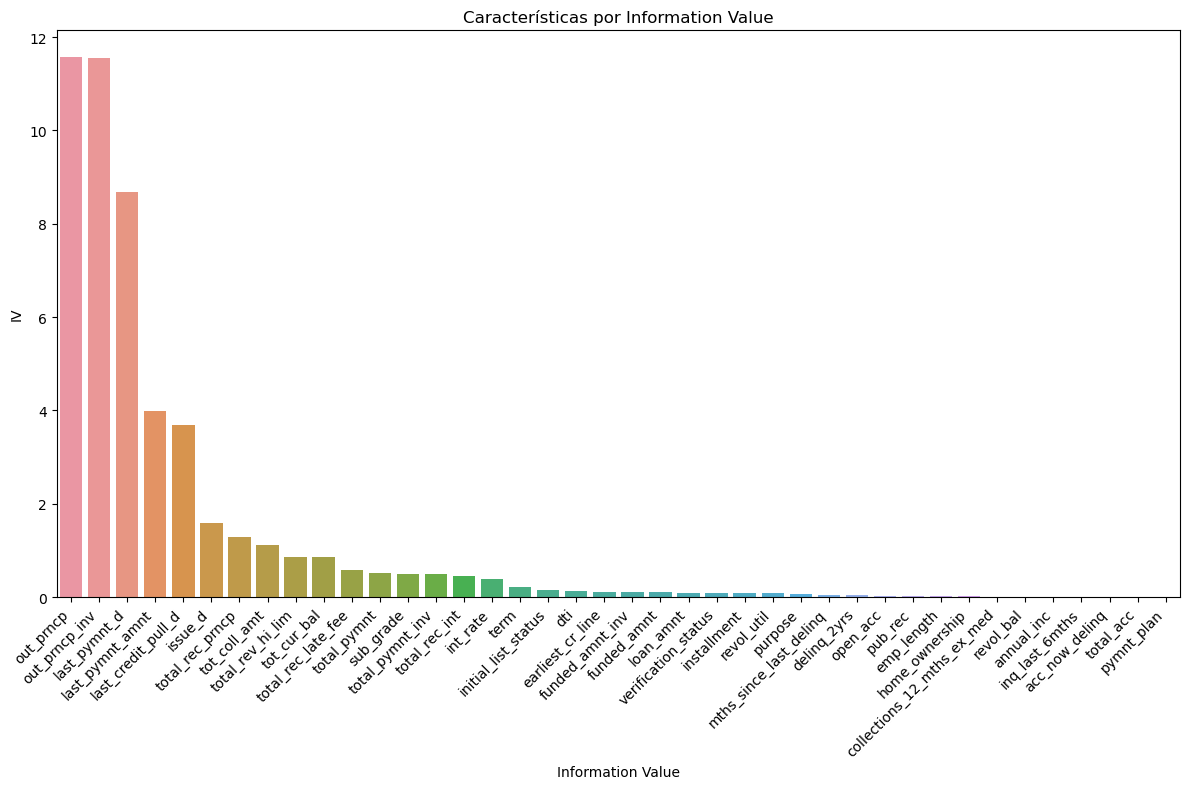

In [62]:
iv_df = pd.DataFrame(iv_summary, columns=['Variable', 'IV']).sort_values(by='IV', ascending=False)

plt.figure(figsize=(12,8))
#sns.barplot(x='IV', y='Feature', data=iv_df.head(20))
sns.barplot(x='Variable', y='IV', data=iv_df)
plt.xticks(rotation=45, ha='right')
plt.title('Características por Information Value')
plt.xlabel('Information Value')
plt.tight_layout()
plt.show()

In [63]:
# Selección de Características según Information Value rango: 0.02 < IV ≤ 0.5

selected_features = iv_df[(iv_df['IV'] > 0.02) & (iv_df['IV'] <= 0.5)]['Variable'].tolist()
selected_dt = selected_features + ['PD']

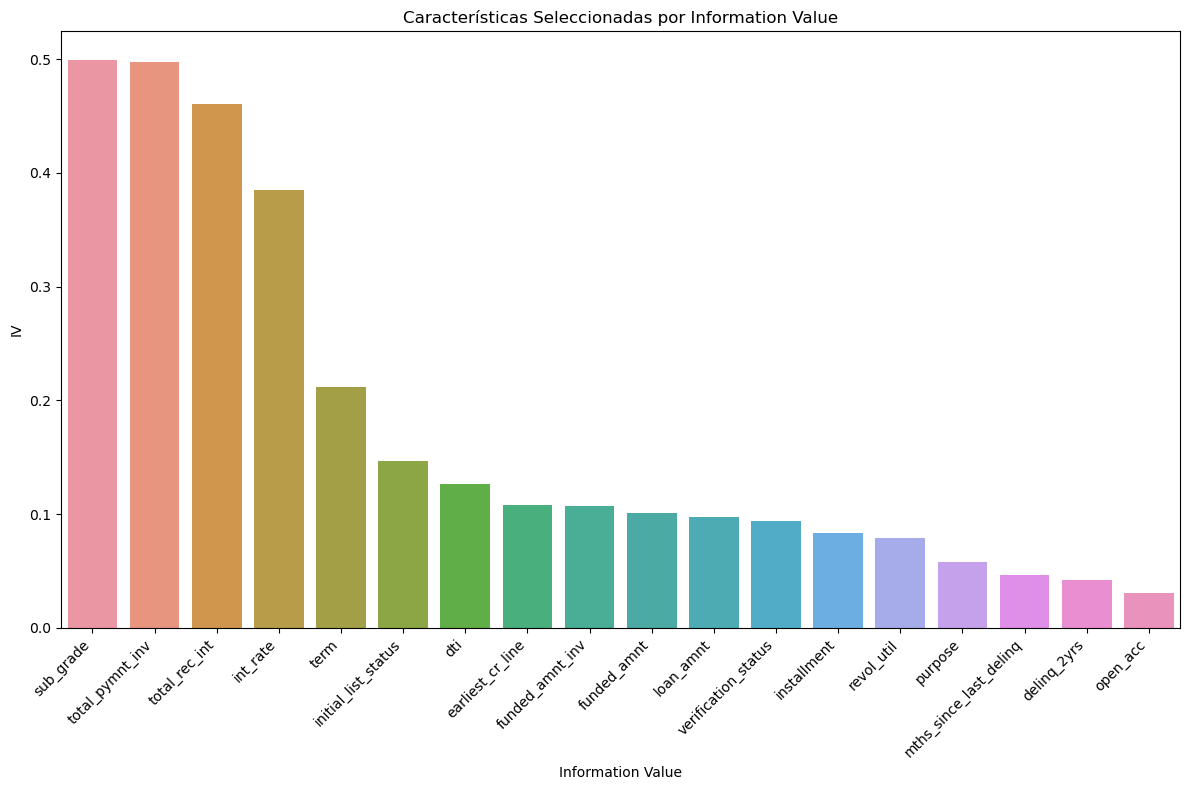

In [64]:
d = iv_df[(iv_df['IV'] > 0.02) & (iv_df['IV'] <= 0.5)]
plt.figure(figsize=(12,8))
#sns.barplot(x='IV', y='Feature', data=iv_df.head(20))
sns.barplot(x='Variable', y='IV', data=d)
plt.xticks(rotation=45, ha='right')
plt.title('Características Seleccionadas por Information Value')
plt.xlabel('Information Value')
plt.tight_layout()
plt.show()

In [65]:
selected_data = X_woe[selected_dt]

In [66]:
# with train_x & train_y data
selected_data

,sub_grade,total_pymnt_inv,total_rec_int,int_rate,term,initial_list_status,dti,earliest_cr_line,funded_amnt_inv,funded_amnt,loan_amnt,verification_status,installment,revol_util,purpose,mths_since_last_delinq,delinq_2yrs,open_acc,PD
id,,,,,,,,,,,,,,,,,,,
547218,-1.443236,0.287065,-0.491702,-1.188715,-0.286637,-0.273132,-0.291674,-0.200555,-0.202545,-0.205618,-0.205132,0.322286,-0.092011,0.094014,-0.096865,-0.180664,-0.089831,-0.266481,0
12506891,-0.330851,0.287065,-0.491702,-0.012417,-0.286637,0.542254,-0.121418,0.245073,-0.202545,-0.205618,-0.205132,-0.445825,-0.092011,0.262687,0.097849,-0.180664,-0.089831,-0.266481,0
1179429,-1.583920,0.820302,-1.464276,-1.188715,-0.286637,-0.273132,-0.121418,-0.228726,-0.559965,-0.536421,-0.528803,0.322286,-0.603765,-0.604087,0.097849,0.052429,-0.089831,0.244036,0
8064606,0.622270,-0.607794,0.203955,0.672354,-0.286637,-0.273132,-0.291674,-0.061909,0.034560,0.031786,0.038690,-0.445825,0.192125,-0.071888,0.097849,-0.180664,-0.089831,0.244036,0
1031471,-1.443236,0.820302,-0.491702,-1.188715,-0.286637,-0.273132,0.523538,0.000825,-0.559965,-0.536421,-0.528803,0.071992,-0.603765,-0.071888,0.097849,-0.180664,-0.089831,0.073400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846992,0.875391,-1.363115,0.779045,0.672354,0.750766,-0.273132,-0.121418,-0.164948,0.440719,0.433698,0.422840,0.322286,0.273965,0.262687,0.097849,0.237603,0.268219,-0.051371,0
1336401,-0.248017,0.287065,-0.126997,-0.012417,-0.286637,-0.273132,-0.291674,0.468051,-0.202545,-0.205618,-0.205132,-0.445825,-0.092011,0.094014,-0.046996,-0.180664,-0.089831,0.020712,0
6115662,1.054276,-1.363115,0.779045,0.672354,0.750766,-0.273132,0.523538,0.013888,0.440719,0.433698,0.422840,0.071992,0.273965,0.262687,-0.046996,-0.180664,-0.089831,0.244036,0


In [68]:
train_x = selected_data[selected_features]
train_y = selected_data['PD']

In [115]:
test_x_woe

,sub_grade,total_pymnt_inv,total_rec_int,int_rate,term,initial_list_status,dti,earliest_cr_line,funded_amnt_inv,funded_amnt,loan_amnt,verification_status,installment,revol_util,purpose,mths_since_last_delinq,delinq_2yrs,open_acc
id,,,,,,,,,,,,,,,,,,
18975871,-0.123908,-1.363115,-1.464276,-0.012417,-0.286637,0.542254,-0.291674,0.077648,0.440719,0.433698,0.422840,0.071992,0.273965,-0.604087,0.097849,-0.180664,-0.089831,0.073400
34943383,-0.248017,-0.607794,-1.464276,-0.650217,-0.286637,-0.273132,0.523538,0.268151,0.166282,0.154936,0.152652,0.322286,0.192125,-0.604087,0.097849,-0.180664,-0.089831,0.073400
14590902,0.402450,-0.607794,0.203955,0.311472,-0.286637,0.542254,-0.481831,0.326800,0.166282,0.154936,0.152652,0.071992,0.273965,-0.071888,0.097849,0.103339,-0.089831,-0.051371
875266,0.392444,0.820302,-0.491702,0.311472,-0.286637,-0.273132,0.523538,-0.078716,-0.559965,-0.536421,-0.528803,0.071992,-0.603765,0.094014,0.097849,-0.180664,-0.089831,-0.051371
1428375,0.402450,-1.363115,0.779045,0.672354,-0.286637,-0.273132,-0.121418,0.264058,0.440719,0.433698,0.422840,0.071992,0.273965,0.094014,0.097849,0.103339,-0.089831,0.244036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542984,-0.123908,-0.289819,0.203955,0.311472,-0.286637,-0.273132,-0.291674,-0.085165,0.034560,0.031786,0.038690,0.322286,0.038534,0.138889,0.097849,0.103339,-0.089831,-0.266481
12978436,-0.248017,-0.607794,0.203955,-0.012417,-0.286637,-0.273132,-0.481831,-0.382190,0.166282,0.154936,0.152652,0.071992,0.192125,-0.604087,-0.080424,0.237603,0.268219,0.244036
1221008,-1.575660,0.820302,-1.464276,-1.188715,-0.286637,-0.273132,0.102230,-0.004879,-0.559965,-0.536421,-0.528803,0.071992,-0.603765,-0.604087,-1.091528,-0.180664,-0.089831,-0.266481


In [117]:
test_data = test_x_woe.join(test_y, how='inner')

In [118]:
test_data.to_csv('credit_test_data.csv', index=False)

# Modelo 

In [70]:
test_x_woe = woe_encoder.transform(test_x) #Aplicar WoEs al set de test_x

In [71]:
model = LogisticRegression()
model.fit(train_x, train_y)

LogisticRegression()

In [81]:
cols = train_x.columns
test_x_woe = test_x_woe[cols]

# Predicción binaria (0/1)
preds = model.predict(test_x_woe)

# Probabilidades

probs = model.predict_proba(test_x_woe)[:, 1]

# Evaluación
print(classification_report(test_y, preds))
print("ROC AUC:", roc_auc_score(test_y, probs))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     36945
           1       0.97      0.68      0.80      2422

    accuracy                           0.98     39367
   macro avg       0.98      0.84      0.89     39367
weighted avg       0.98      0.98      0.98     39367

ROC AUC: 0.9330218027802392


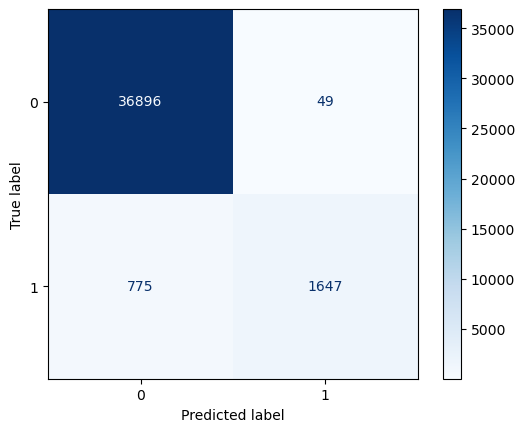

In [83]:
# Calcula la matriz
cm = confusion_matrix(test_y, preds)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")


In [84]:
from sklearn.metrics import roc_curve, auc

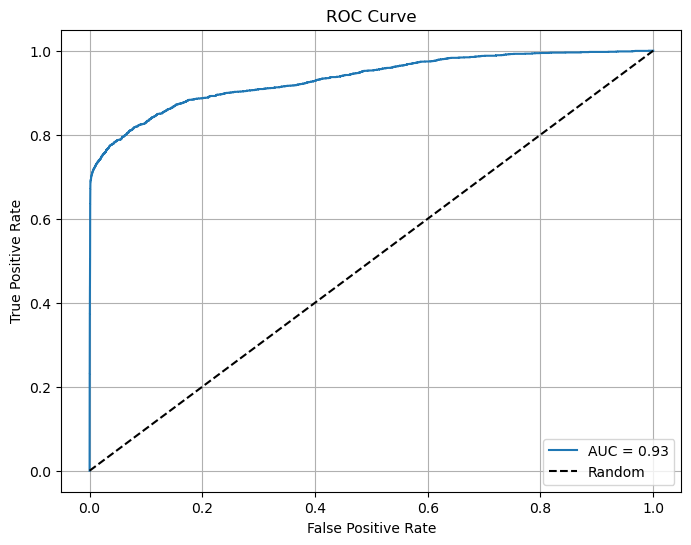

In [85]:
# ROC
fpr, tpr, thresholds = roc_curve(test_y, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [110]:
probs2

array([4.63007072e-05, 5.12466099e-04, 3.66134049e-02, ...,
       8.58678652e-04, 4.40817494e-03, 1.20862952e-01])

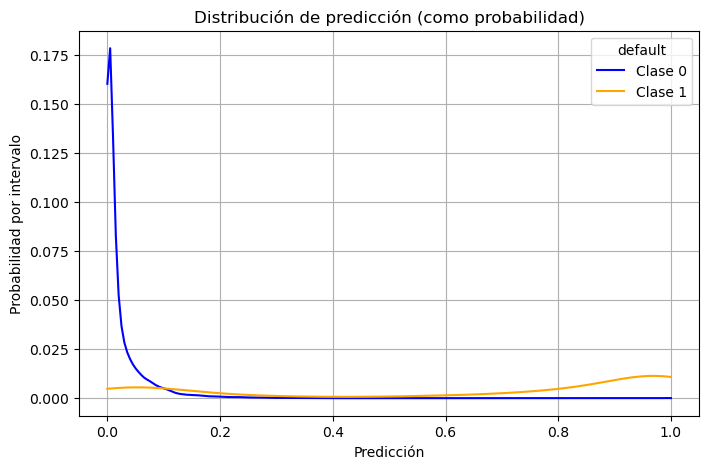

In [114]:
# Crear un DataFrame con las predicciones y la clase real
probs2 = np.squeeze(np.array(probs))

testy = np.squeeze(np.array(test_y))

df_plot = pd.DataFrame({
    "prediction": probs2,
    "default": testy  # o como se llame tu variable objetivo
})

# Separar por clase
pred_0 = df_plot[df_plot["default"] == 0]["prediction"]
pred_1 = df_plot[df_plot["default"] == 1]["prediction"]

# KDE manual para ambos
kde_0 = gaussian_kde(pred_0)
kde_1 = gaussian_kde(pred_1)

x_vals = np.linspace(0, 1, 200)
pdf_0 = kde_0(x_vals)
pdf_1 = kde_1(x_vals)

# Convertir densidades a probabilidad por bin (aproximado)
bin_width = x_vals[1] - x_vals[0]
prob_0 = pdf_0 * bin_width
prob_1 = pdf_1 * bin_width

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(x_vals, prob_0, label="Clase 0", color="blue")
plt.plot(x_vals, prob_1, label="Clase 1", color="orange")
plt.title("Distribución de predicción (como probabilidad)")
plt.xlabel("Predicción")
plt.ylabel("Probabilidad por intervalo")
plt.legend(title="default")
plt.grid(True)
plt.show()

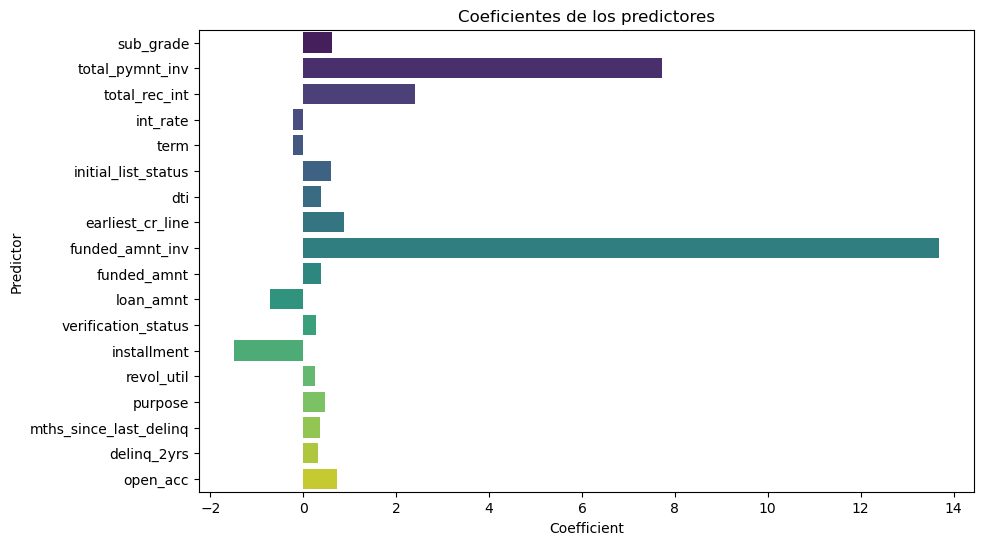

In [99]:
# Obtener los coeficientes del modelo
coef = model.coef_
coef = coef.flatten()

# Crear un DataFrame para los coeficientes
coef_df = pd.DataFrame({'Predictor': train_x.columns, 'Coefficient': coef})

# Crear un barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Predictor', data=coef_df, palette='viridis')
plt.title('Coeficientes de los predictores')
plt.show()

In [119]:
# Asegúrate de que coef esté aplanado


# Crear el diccionario
coef_dict = dict(zip(train_x.columns, coef))

# Mostrarlo
print(coef_dict)


{'sub_grade': 0.6235234012485648, 'total_pymnt_inv': 7.721839083091198, 'total_rec_int': 2.4026155862752554, 'int_rate': -0.2303365617137526, 'term': -0.21199153987635885, 'initial_list_status': 0.6072187625485854, 'dti': 0.3832970586351636, 'earliest_cr_line': 0.876053240006344, 'funded_amnt_inv': 13.679504284086525, 'funded_amnt': 0.3914324028636166, 'loan_amnt': -0.7078673679533461, 'verification_status': 0.2737730674638748, 'installment': -1.4883783856432622, 'revol_util': 0.2525334408966414, 'purpose': 0.4618232575843269, 'mths_since_last_delinq': 0.35302114281900643, 'delinq_2yrs': 0.32294092241918193, 'open_acc': 0.7367958736436964}
